### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Calculate ADC' (Prime)
#### I have a feeling this would be much more useful if it took arrays as inputs and outputted an array. But this current method is good for the list comprehension line. 

In [2]:
def calc_adc_prime(adc, sigma, axr, tm):
   adc_prime = adc * (1 - sigma* np.exp(-tm*axr))
   return adc_prime

def calc_adc_prime_array(adc, sigma, axr, tm):
   """not clear that this function is working as intended
   Not currently used"""
   adc = torch.tensor(adc)
   sigma = torch.tensor(sigma)
   axr = torch.tensor(axr)

   tm = np.broadcast_to(tm, (adc.shape[0], 8))
   tm = torch.tensor(tm)

   adc = adc.numpy()
   sigma = sigma.numpy()
   axr = axr.numpy()
   tm = tm.numpy()
   

   #maybe put a for loop here. Or you could 'pad out' the tm and sigma arrays so that they are the same size as adc and axr
   adc_prime = adc * (1 - sigma * np.exp(-tm * axr))
   return adc_prime


### Simulate Signal

In [3]:
def simulate_sig(adc, sigma, axr, bf, be, tm, acq):
    """Generate an normalised output signal s based on known inputs for a given voxel
Inputs  - adc:      apparent diffusion coefficient [m2/s]
        - sigma:    filter efficiency
        - axr:      exchange rate [1/s]
        - bf:       filter block b-value [m2/s]
        - be:       encoding block b-value [m2/s]
        - tm:       mixing time [s]

Output: - s:        signal (sum of the magnetisations) single value
   Based off Elizabeth's code
    """

    if bf == 0 and tm[acq] == min(tm):
        tm[acq] = np.inf

    #calculate ADC as fnc of mixing time

    adc_prime = calc_adc_prime(adc,sigma,axr,tm[acq])

    #compute signal
    normalised_signal = np.exp(-adc_prime*be)

    return normalised_signal, adc_prime
    

### Initial variables.

In [4]:
nvox = 200 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e6   # filter b-values [s/m2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e6       # encoding b-values [s/m2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400]) * 1e-3  # mixing time [s]


sim_adc = np.random.uniform(1e-10,3.5e-9,nvox)                # ADC, simulated [m2/s]
sim_sigma = np.random.uniform(0,1,nvox)                 # sigma, simulated [a.u.]
sim_axr = np.random.uniform(0.1,20,nvox)                       # AXR, simulated [s-1]

# simulate signals    
sigs_and_adc_prime = np.array([[simulate_sig(sim_adc[voxel], sim_sigma[voxel], sim_axr[voxel], bf[acq], be[acq], tm, acq) 
                    for acq in range(np.size(tm))] 
                    for voxel in range(nvox)])

#sim_E_vox is the signal
sim_E_vox = sigs_and_adc_prime[:, :, 0]
sim_adc_prime = sigs_and_adc_prime[:, :, 1]

### Plotting b-value against normalised signal

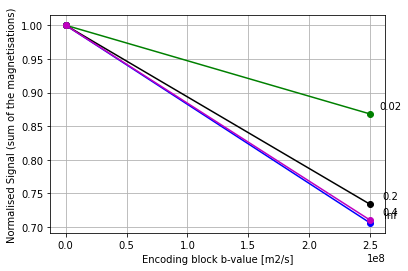

In [5]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Creating the neural network

In [6]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nparams,batch_size):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        self.batch_size = batch_size

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 
        adc = torch.clamp(params[:,0].unsqueeze(1), min=1e-10, max=3.5e-9)
        """I have a feeling adc is worst plot because it is e9 or e10, wheres others are between 0-1 or 20 
        """
        sigma = torch.clamp(params[:,1].unsqueeze(1), min=0, max=1)
        axr = torch.clamp(params[:,2].unsqueeze(1), min=.1, max=20)

        sigs_and_adc_prime = np.array([[simulate_sig(sim_adc[voxel], sim_sigma[voxel], sim_axr[voxel], self.bf[acq], self.be[acq], self.tm, acq) 
                    for acq in range(self.tm.size()[0])]
                    for voxel in range(self.batch_size)])

        signals = sigs_and_adc_prime[:, :, 0]        
        E_vox = torch.tensor(signals)

        return E_vox, adc, sigma, axr


### NN continued

In [7]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)
batch_size = 128

#initilise network
net = Net(be, bf, tm, nparams, batch_size)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

### Training

In [8]:
"""Unchanged and untouch from snighda
Have not made changes. 
"""
# train
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)
        
        loss = criterion(pred_E_vox, sim_E_vox_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc, final_pred_sigma, final_pred_axr = net(torch.from_numpy(sim_E_vox.astype(np.float32)))

-----------------------------------------------------------------
epoch: 0; bad epochs: 0


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([128, 8])
torch.Size([128, 8])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Plots

In [ ]:
# check predicted signal against simulated signal
# is this correct for FEXI
plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()


param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
